In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/hw3-model/model.pth
/kaggle/input/ml2019spring-hw3/sample.csv
/kaggle/input/ml2019spring-hw3/test.csv
/kaggle/input/ml2019spring-hw3/train.csv


In [2]:
import sys
import csv
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [3]:
def readfile(path):
    print("Reading File...")
    x_train = []
    x_label = []
    val_data = []
    val_label = []

    raw_train = np.genfromtxt(path, delimiter=',', dtype=str, skip_header=1)
    for i in range(len(raw_train)):
        tmp = np.array(raw_train[i, 1].split(' ')).reshape(1, 48, 48)
        if (i % 10 == 0):
            val_data.append(tmp)
            val_label.append(raw_train[i][0])
        else:
            x_train.append(tmp)
            x_train.append(np.flip(tmp, axis=2))    # simple example of data augmentation
            #x_train.append(np.flip(tmp, axis=1))
            #x_train.append(np.rot90(tmp,1,(1,2)))
            #x_label.append(raw_train[i][0])
            #x_label.append(raw_train[i][0])
            x_label.append(raw_train[i][0])
            x_label.append(raw_train[i][0])

    x_train = np.array(x_train, dtype=float) / 255.0
    val_data = np.array(val_data, dtype=float) / 255.0
    x_label = np.array(x_label, dtype=int)
    val_label = np.array(val_label, dtype=int)
    x_train = torch.FloatTensor(x_train)
    val_data = torch.FloatTensor(val_data)
    x_label = torch.LongTensor(x_label)
    val_label = torch.LongTensor(val_label)

    return x_train, x_label, val_data, val_label

x_train, x_label, val_data, val_label = readfile('../input/ml2019spring-hw3/train.csv')    # 'train.csv'

Reading File...


In [4]:
train_set = TensorDataset(x_train, x_label)
val_set = TensorDataset(val_data, val_label)

batch_size = 256
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=8)

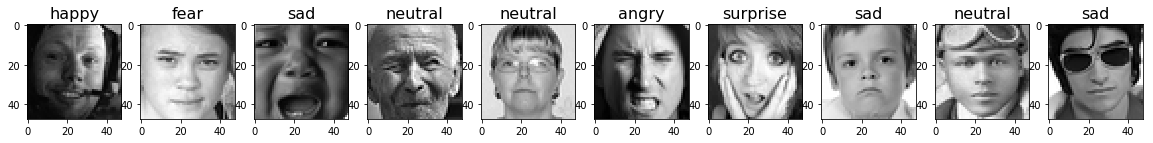

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import torchvision

# functions to show an image

classes = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
num_show = 10
img_show = np.random.choice(batch_size, num_show)
fig, axes = plt.subplots(1, num_show, figsize = (20, 2))
for i, j in enumerate(img_show):
    axes[i].set_title(classes[labels[j]], fontsize = 16)
    axes[i].imshow(images[j].numpy().squeeze(), cmap = 'gray')

In [6]:
def gaussian_weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 and classname.find('Conv') == 0:
        m.weight.data.normal_(0.0, 0.02)


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),  # [64, 48, 48]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Dropout(p=0.3), # [64, 24, 24]

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      
            nn.Dropout(p=0.3),   # [128, 12, 12]
            
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      
            nn.Dropout(p=0.3),   # [256, 6, 6]
            
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      
            nn.Dropout(p=0.4),   # [512, 3, 3]
        )

        self.fc = nn.Sequential(  #fully connected layers
            nn.Linear(512*3*3, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 7),
        )

        self.cnn.apply(gaussian_weights_init)
        self.fc.apply(gaussian_weights_init)

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

## hw3_training

In [7]:
model = Classifier().cuda()
# print(model)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
best_acc = 0.0
num_epoch = 150
train_loss_record = []
train_acc_record = []
val_loss_record = []
val_acc_record = []


for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        train_pred = model(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

        progress = ('#' * int(float(i)/len(train_loader)*40)).ljust(40)
        print ('[%03d/%03d] %2.2f sec(s) | %s |' % (epoch+1, num_epoch, \
                (time.time() - epoch_start_time), progress), end='\r', flush=True)
    
    model.eval()
    for i, data in enumerate(val_loader):
        val_pred = model(data[0].cuda())
        batch_loss = loss(val_pred, data[1].cuda())

        val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        val_loss += batch_loss.item()

        progress = ('#' * int(float(i)/len(val_loader)*40)).ljust(40)
        print ('[%03d/%03d] %2.2f sec(s) | %s |' % (epoch+1, num_epoch, \
                (time.time() - epoch_start_time), progress), end='\r', flush=True)

    val_acc = val_acc/val_set.__len__()
    train_acc = train_acc/train_set.__len__()
    train_loss_record.append(train_loss)
    train_acc_record.append(train_acc)
    val_loss_record.append(val_loss)
    val_acc_record.append(val_acc)
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc, train_loss, val_acc, val_loss))

[001/150] 10.90 sec(s) Train Acc: 0.256018 Loss: 364.932539 | Val Acc: 0.280738 loss: 23.288115
[002/150] 10.06 sec(s) Train Acc: 0.381608 Loss: 316.156788 | Val Acc: 0.395333 loss: 19.619249
[003/150] 10.10 sec(s) Train Acc: 0.430548 Loss: 292.580483 | Val Acc: 0.486938 loss: 17.063509
[004/150] 10.06 sec(s) Train Acc: 0.454640 Loss: 281.002536 | Val Acc: 0.498433 loss: 16.537165
[005/150] 10.08 sec(s) Train Acc: 0.475869 Loss: 271.685602 | Val Acc: 0.503657 loss: 16.482682
[006/150] 10.35 sec(s) Train Acc: 0.489570 Loss: 265.315221 | Val Acc: 0.500174 loss: 16.790150
[007/150] 10.13 sec(s) Train Acc: 0.498742 Loss: 260.776699 | Val Acc: 0.518286 loss: 15.454475
[008/150] 10.07 sec(s) Train Acc: 0.509850 Loss: 255.649471 | Val Acc: 0.466040 loss: 15.821199
[009/150] 10.07 sec(s) Train Acc: 0.514204 Loss: 252.904573 | Val Acc: 0.565308 loss: 14.593471
[010/150] 10.05 sec(s) Train Acc: 0.526473 Loss: 248.927156 | Val Acc: 0.543365 loss: 15.169936
[011/150] 10.05 sec(s) Train Acc: 0.5330

In [8]:
hw3_record = [['train_loss', 'train_acc', 'val_loss', 'val_acc']]
for i in range(len(train_loss_record)):
    hw3_record.append([train_loss_record[i], train_acc_record[i], val_loss_record[i], val_acc_record[i]])
with open('hw3_record.csv', 'w') as hw3_recordFile:
    writer = csv.writer(hw3_recordFile)
    writer.writerows(hw3_record)

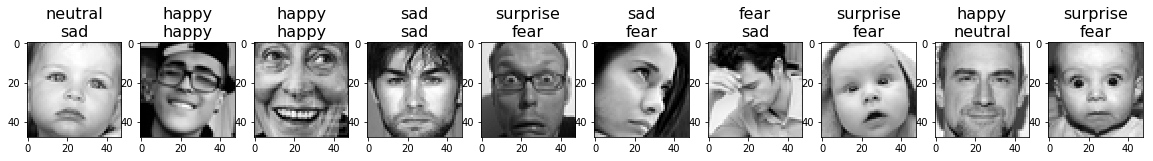

In [9]:
valiter = iter(val_loader)
images, labels = valiter.next()
val_pred = model(images.cuda())
predictions = np.argmax(val_pred.cpu().data.numpy(), axis=1)
num_show = 10
img_show = np.random.choice(batch_size, num_show)
fig, axes = plt.subplots(1, num_show, figsize = (20, 2))
for i, j in enumerate(img_show):
    axes[i].set_title('{true}\n{predicted}'.format(true = classes[labels[j]], predicted = classes[predictions[j]]), fontsize = 16)
    axes[i].imshow(images[j].numpy().squeeze(), cmap = 'gray')

In [10]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        val_pred = model(images.cuda())
        predicted = np.argmax(val_pred.cpu().data.numpy(), axis=1)
        c = (predicted == labels.numpy()).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of angry : 38 %
Accuracy of disgust : 13 %
Accuracy of  fear : 48 %
Accuracy of happy : 72 %
Accuracy of   sad : 81 %
Accuracy of surprise : 42 %
Accuracy of neutral : 47 %


[Text(0, 0.5, 'angry'),
 Text(0, 1.5, 'disgust'),
 Text(0, 2.5, 'fear'),
 Text(0, 3.5, 'happy'),
 Text(0, 4.5, 'sad'),
 Text(0, 5.5, 'surprise'),
 Text(0, 6.5, 'neutral')]

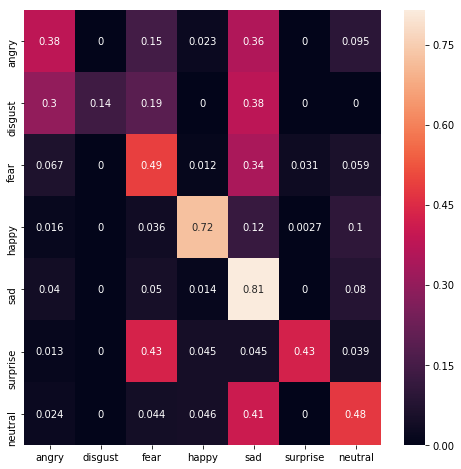

In [11]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_true = np.array([])
y_pred = np.array([])
for data in val_loader:
    images, labels = data
    y_true = np.append(y_true, labels)
    pred = np.argmax(model(images.cuda()).cpu().data.numpy(), axis=1)
    y_pred = np.append(y_pred, pred)
cm = confusion_matrix(y_true, y_pred, labels = list(range(7)))
cm = cm.astype(float)
for i in range(7):
    temp = np.sum(cm[i])
    for j in range(7):
        cm[i][j] = cm[i][j] / temp
fig, ax = plt.subplots(figsize = (8,8))
ax = sns.heatmap(cm, annot = True)
ax.set_xticklabels (classes)
ax.set_yticklabels (classes)

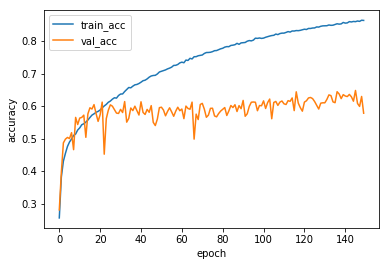

In [12]:
fig, ax = plt.subplots()
ax.plot(list(range(len(train_acc_record))), train_acc_record)
ax.plot(list(range(len(val_acc_record))), val_acc_record)
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train_acc', 'val_acc'])

In [13]:
def readtestfile(path):
    print("Reading File...")
    x_test = []
    x_label = []

    raw_test = np.genfromtxt(path, delimiter=',', dtype=str, skip_header=1)
    for i in range(len(raw_test)):
        tmp = np.array(raw_test[i, 1].split(' ')).reshape(1, 48, 48)
        x_test.append(tmp)
        x_label.append(raw_test[i][0])

    x_test = np.array(x_test, dtype=float) / 255.0
    x_label = np.array(x_label, dtype=int)
    x_test = torch.FloatTensor(x_test)
    x_label = torch.LongTensor(x_label)

    return x_test, x_label


x_test, x_test_label = readtestfile('../input/ml2019spring-hw3/test.csv')    # 'test.csv'
test_set = TensorDataset(x_test, x_test_label)
test_loader = DataLoader(test_set, num_workers=8)

Reading File...


In [14]:
#torch.save(model.state_dict(), 'model.pth')

In [15]:
submission = [['id', 'label']]
for i, data in enumerate(test_loader):
    test_pred = model(data[0].cuda())
    pred = np.argmax(test_pred.cpu().data.numpy(), axis=1)[0]
    submission.append([i, pred])

In [16]:
with open('submission.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerows(submission)

=> 0.65645

hw4_report

In [17]:
device = torch.device('cpu')
model = Classifier().cuda()
model.load_state_dict(torch.load("../input/hw3-model/model.pth", map_location=device))

<All keys matched successfully>

In [18]:
def compute_saliency_maps(x, y, model):
    model.eval()
    x.requires_grad_()
    y_pred = model(x.cuda())
    loss_func = torch.nn.CrossEntropyLoss()
    loss = loss_func(y_pred, y.cuda())
    loss.backward()

    saliency = x.grad.abs().squeeze().data
    return saliency

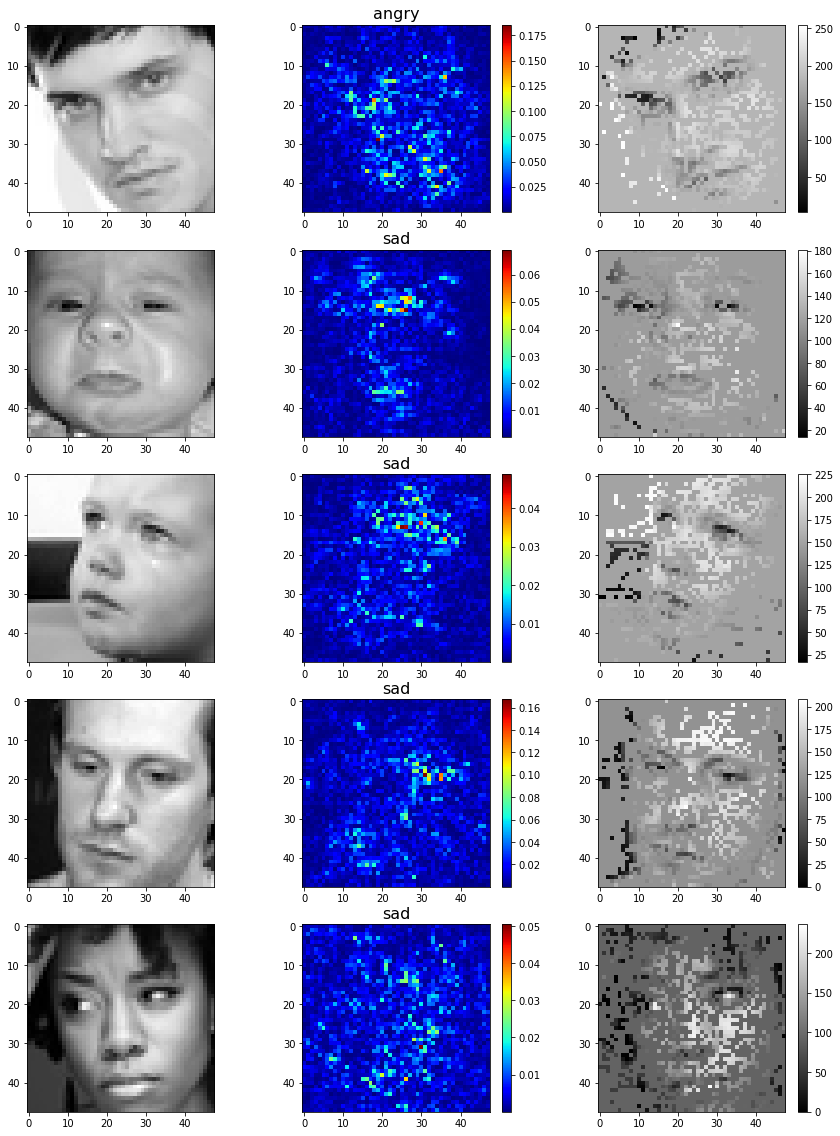

In [19]:
def show_saliency_maps(x, y, model):
    x_org = x.squeeze().numpy()
    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(x, y, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.detach().cpu().numpy()
    
    num_pics = x_org.shape[0]
    '''
    for i in range(num_pics):
        # You need to save as the correct fig names
        plt.imsave('pic_'+ str(i), x_org[i], cmap=plt.cm.gray)
        plt.imsave('saliency_'+ str(i), saliency[i], cmap=plt.cm.jet)'''
    
    fig, axes = plt.subplots( num_pics, 3, figsize = (15, 20))
    
    for i in range(num_pics):
        axes[i, 0].imshow(x_org[i], cmap = plt.cm.gray)
        axes[i, 1].set_title(classes[y[i]], fontsize = 16)
        ax1 = axes[i, 1].imshow(saliency[i], cmap = plt.cm.jet)
        threshold = saliency[i].mean()
        arraySee = (x_org[i]*255).reshape(48, 48)
        arraySee[np.where(saliency[i] <= threshold)] = np.mean(arraySee)
        ax2 = axes[i, 2].imshow(arraySee, cmap = 'gray')
        fig.colorbar(ax1, ax=axes[i, 1])
        fig.colorbar(ax2, ax=axes[i, 2])
    
# using the first ten images for example
idx_show = np.random.choice(len(x_train), 5)
show_saliency_maps(x_train[idx_show], x_label[idx_show], model)

Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


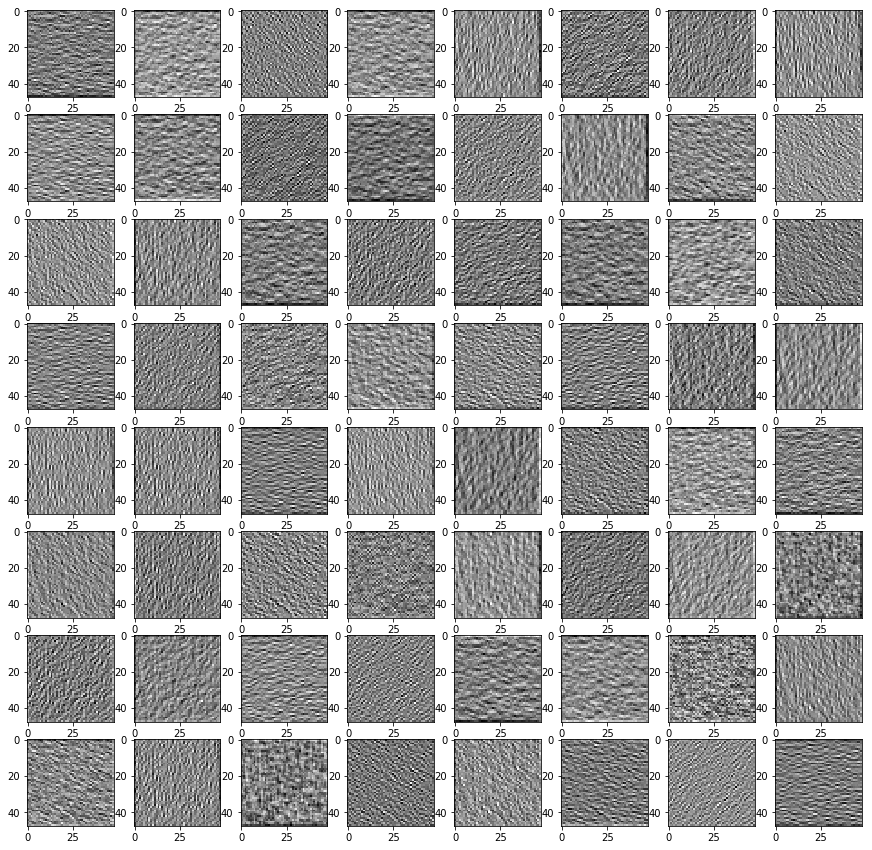

In [20]:
from torchvision import transforms, utils
from torch.optim import Adam
from skimage.segmentation import slic
from skimage.color import gray2rgb, rgb2gray
from lime import lime_image
import argparse
#filter visualization, output of conv1
#use forward hook
device = torch.device('cpu')
model = Classifier().cuda()
model.load_state_dict(torch.load("../input/hw3-model/model.pth", map_location=device))
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook
#Conv2d
print(model.cnn[0])
model.cnn[0].register_forward_hook(get_activation('conv1'))
model.eval()
random_image = np.uint8(np.random.uniform(0, 255, (48, 48, 1)))
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])
output = model(transform(random_image).view(-1,1,48,48).cuda())

act = activation['conv1'].detach().squeeze().cpu()

plt.figure(figsize=(15,15))
for i in range(8):
    for j in range(8):
        plt.subplot(8,8,i*8+j+1)
        plt.imshow(act[i*8+j], cmap = plt.cm.gray)

Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


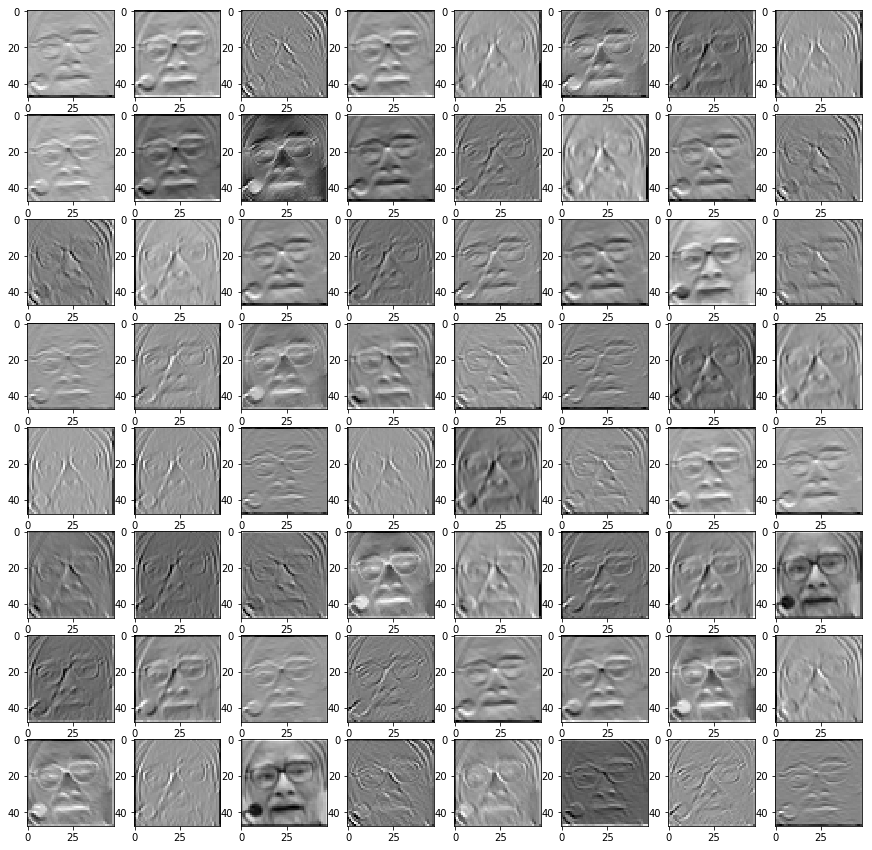

In [21]:
#filter visualization, output of conv1
#use forward hook
device = torch.device('cpu')
model = Classifier().cuda()
model.load_state_dict(torch.load("../input/hw3-model/model.pth", map_location=device))
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook
#Conv2d
print(model.cnn[0])
model.cnn[0].register_forward_hook(get_activation('conv1'))
model.eval()
output = model(x_train[0].view(-1,1,48,48).cuda())

act = activation['conv1'].detach().squeeze().cpu()

plt.figure(figsize=(15,15))
for i in range(8):
    for j in range(8):
        plt.subplot(8,8,i*8+j+1)
        plt.imshow(act[i*8+j], cmap = plt.cm.gray)

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


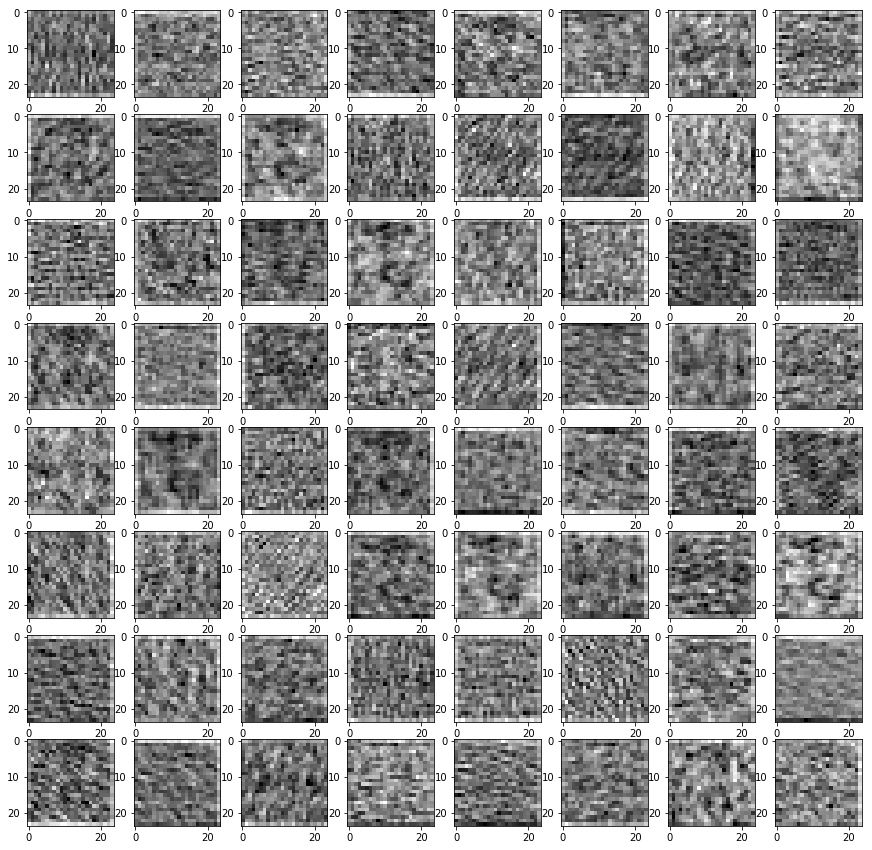

In [22]:
#filter visualization, output of conv1
#use forward hook
device = torch.device('cpu')
model = Classifier().cuda()
model.load_state_dict(torch.load("../input/hw3-model/model.pth", map_location=device))
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook
#Conv2d
print(model.cnn[5])
model.cnn[5].register_forward_hook(get_activation('conv1'))
model.eval()
random_image = np.uint8(np.random.uniform(0, 255, (48, 48, 1)))
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])
output = model(transform(random_image).view(-1,1,48,48).cuda())

act = activation['conv1'].detach().squeeze().cpu()

plt.figure(figsize=(15,15))
for i in range(8):
    for j in range(8):
        plt.subplot(8,8,i*8+j+1)
        plt.imshow(act[i*8+j], cmap = plt.cm.gray)

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


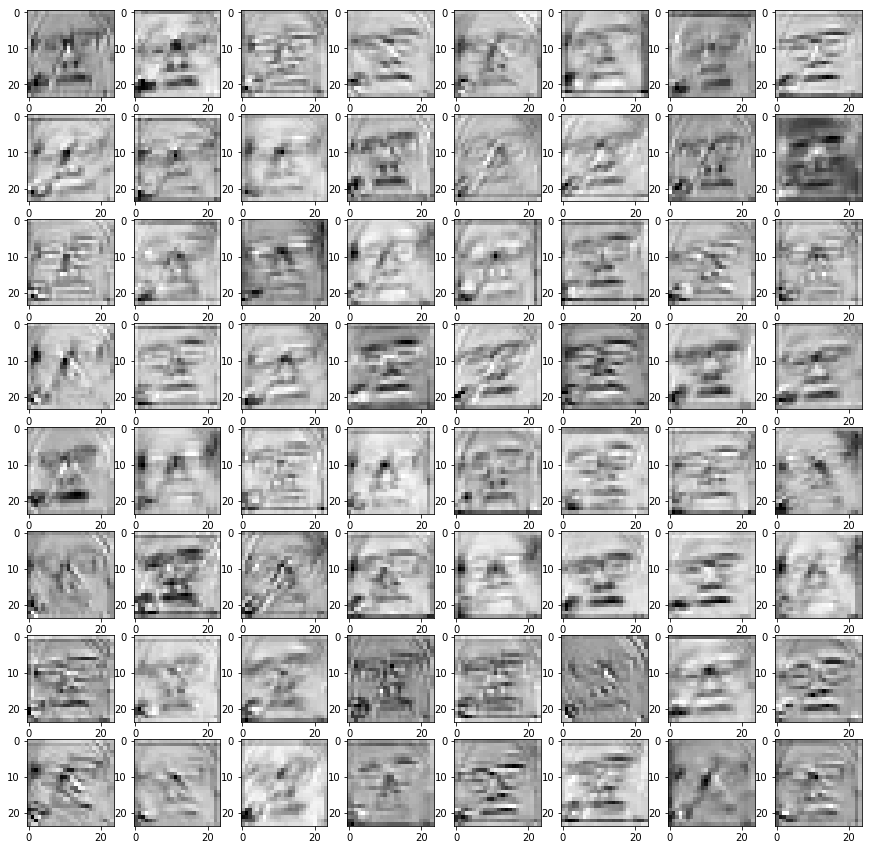

In [23]:
#filter visualization, output of conv1
#use forward hook
device = torch.device('cpu')
model = Classifier().cuda()
model.load_state_dict(torch.load("../input/hw3-model/model.pth", map_location=device))
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook
#Conv2d
print(model.cnn[5])
model.cnn[5].register_forward_hook(get_activation('conv1'))
model.eval()
output = model(x_train[0].view(-1,1,48,48).cuda())

act = activation['conv1'].detach().squeeze().cpu()

plt.figure(figsize=(15,15))
for i in range(8):
    for j in range(8):
        plt.subplot(8,8,i*8+j+1)
        plt.imshow(act[i*8+j], cmap = plt.cm.gray)

gradient accent finish


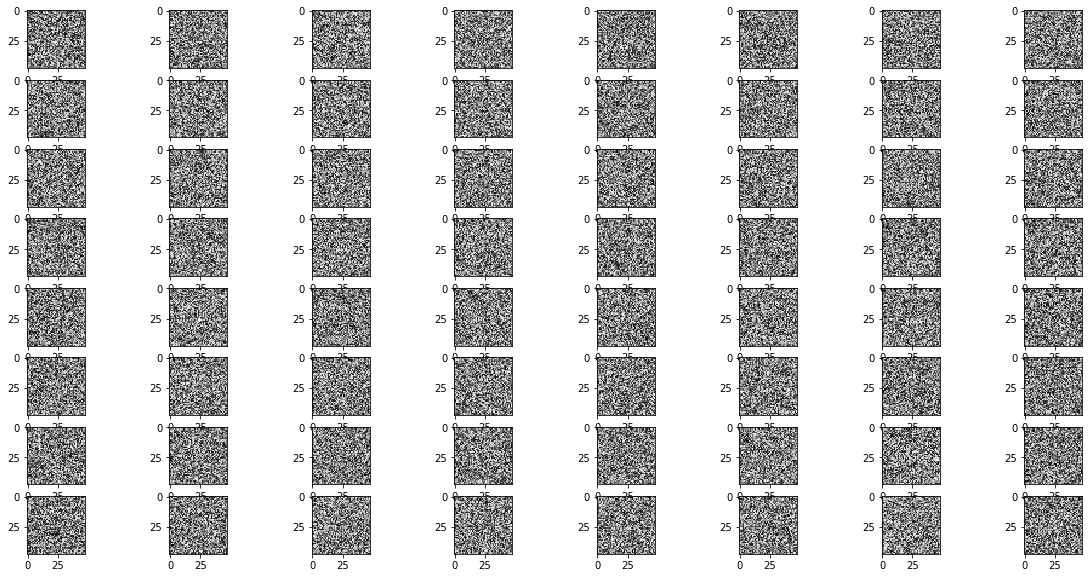

In [24]:
random_image = np.uint8(np.random.uniform(0, 255, (48, 48, 1)))
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])
x = transform(random_image)
x = x.view(-1,1,48,48)
x.requires_grad_()
device = torch.device('cpu')
model = Classifier().cuda()
model.load_state_dict(torch.load("../input/hw3-model/model.pth", map_location=device))
model.cuda()
model.eval()
optimizer = Adam([x], lr=0.01)

plt.figure(figsize=(20,10))
for i in range(64):
    random_image = np.uint8(np.random.uniform(0, 255, (48, 48, 1)))
    x = transform(random_image)
    x = x.view(-1,1,48,48)
    x.requires_grad_()
    optimizer = Adam([x], lr=0.01)
    for j in range(7):
        optimizer.zero_grad()
        output = model(x.cuda())
        loss = -torch.sum(output[0][j])
        loss.backward()
        optimizer.step()
    plt.subplot(8,8,i+1)
    plt.imshow(x.squeeze().detach().numpy(), cmap = plt.cm.gray)
print('gradient accent finish')

/ |#                                               | 1000 Elapsed Time: 0:00:00

done!


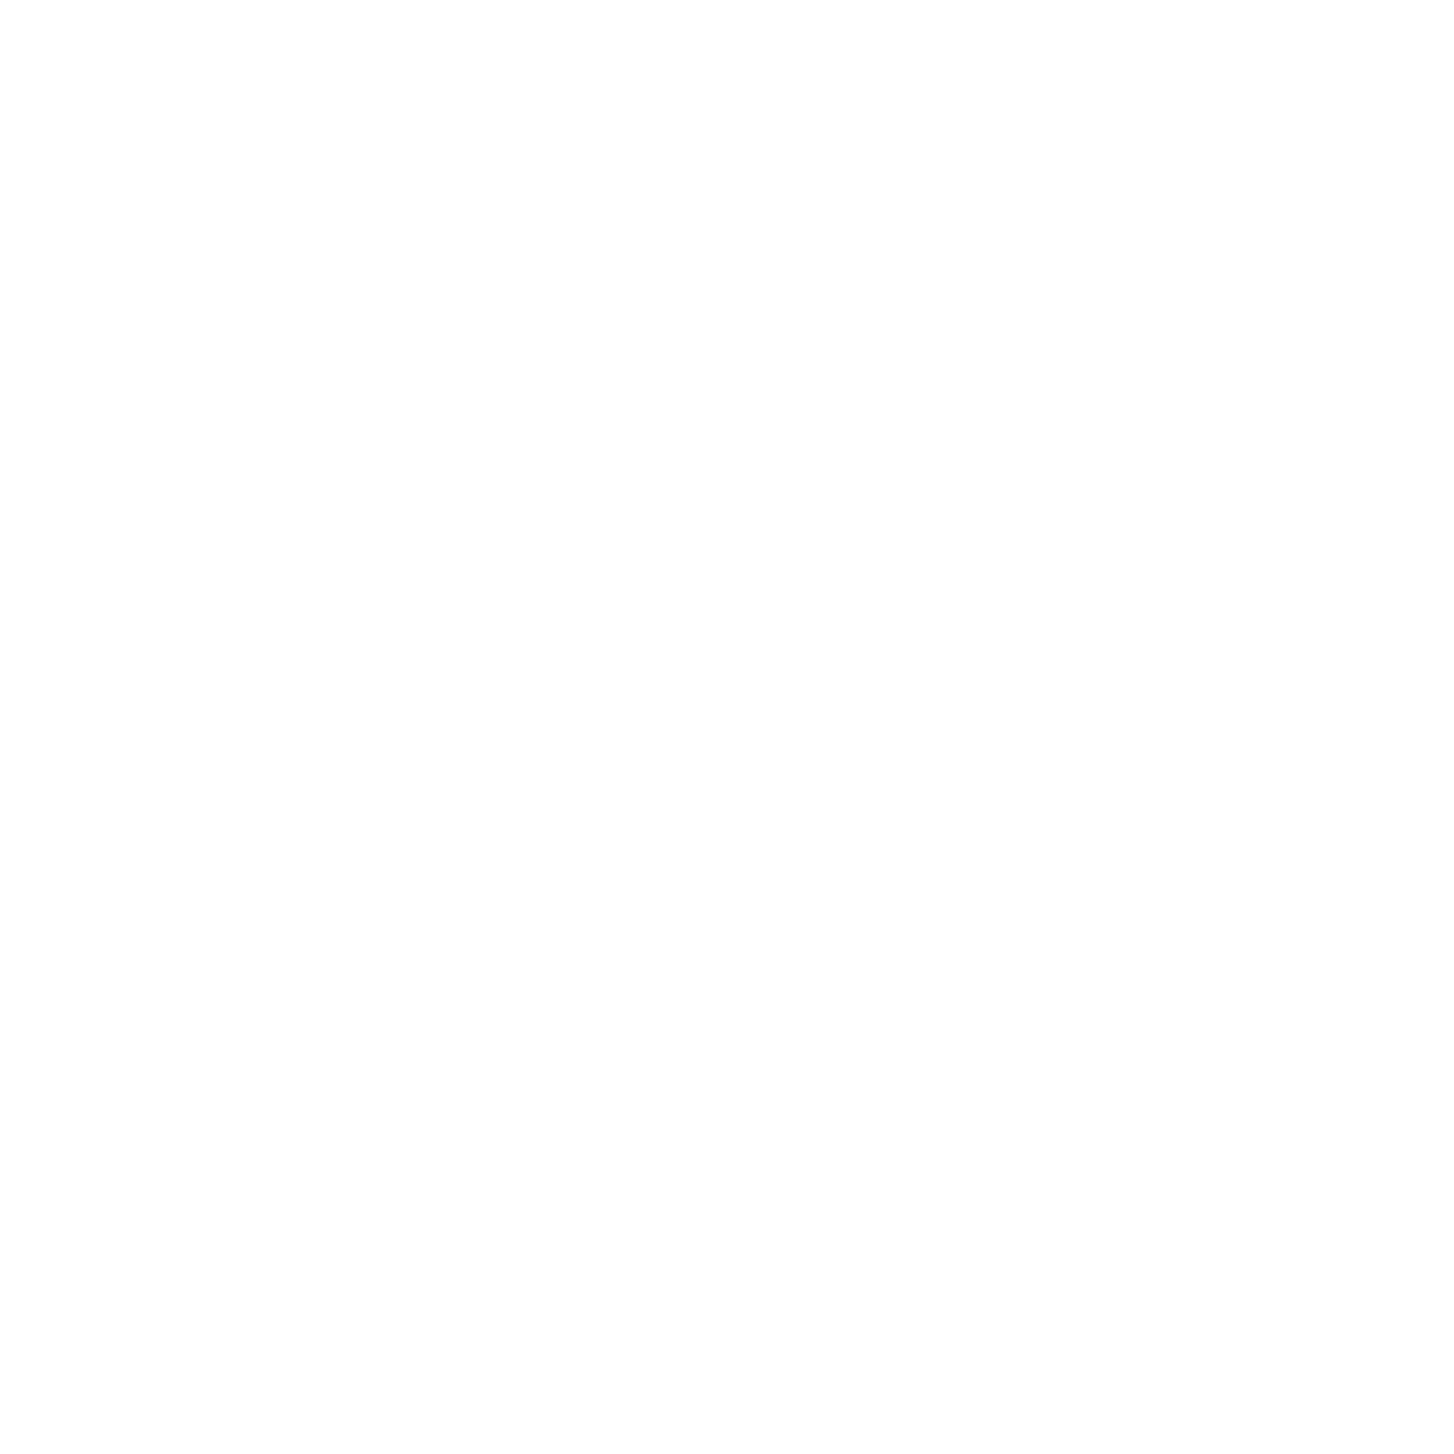

In [25]:
from skimage.segmentation import mark_boundaries
for data in val_loader:
    images, labels = data
def model_predict(np_in):
    global model
    img = np_in[0,:,:, 0]
    img_tnesor = torch.FloatTensor(img)
    img_tnesor = img_tnesor.unsqueeze(0)
    img_tnesor = img_tnesor.unsqueeze(0)
    m = nn.Softmax(dim=1)
    ans = m(model(img_tnesor)).detach().numpy().reshape(7)
    rt = np.zeros((np_in.shape[0], 7))
    for i in range(np_in.shape[0]):
        rt[i] = ans
    return rt
def segmentation(img):
    segments = slic(img, n_segments=100, compactness=10)
    return segments
np.random.seed(0)
explainer = lime_image.LimeImageExplainer()
#fig, axes = plt.subplots(6, 2, figsize = (20, 20))
fig, axes = plt.subplots(6, 1, figsize = (20, 20))
for ip3 in range(6):

    p_33img = np.zeros((48, 48, 3))
    for i in range(3):
        p_33img[:,:, i] = images[ip3].numpy().reshape(48, 48)
    try:
        explaination = explainer.explain_instance(
                                image=p_33img, 
                                classifier_fn=model_predict,
                                segmentation_fn=segmentation
                            )
    except:
        pass
    try:
        p33_rt_image, mask = explaination.get_image_and_mask(
                                    label=ip3,
                                    positive_only=False,
                                    hide_rest=False,
                                    num_features=10,
                                    min_weight=0.0
                                )
        #axes[ip3, 0].imshow(p_33img, cmap = 'jet')
        #axes[ip3, 1].imshow(mark_boundaries(p33_rt_image, mask).reshape((48, 48, 3)), cmap = 'jet')
        axes[ip3].imshow(mark_boundaries(p33_rt_image, mask).reshape((48, 48, 3)), cmap = 'jet')
    except:
        axes[ip3].set_visible(False)
        pass

print('done!')